# Disaster tweet analysis

This notebook will look at comparing a few different models to predict if tweets are talking about a real disaster or not. The data is from kaggle (https://www.kaggle.com/c/nlp-getting-started/overview).

For example, a tweet might say "on the plus side look at the sky last night it was ablaze". The word ablaze could mean there is a disaster or in this case the sky was colorful, so no disaster. We want to try and train our models to that they can distinguish the real meaning of the tweet. 

The models I will be comparing are different recurrent neural networks, specifically long short-term memory and gated recurrent unit models. I will then try to optimize a few hyperparameters or add already built embeddings to try and get a better model. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import re
import nltk
import emoji
from nltk.corpus import stopwords
from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding, Dropout
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping


2024-04-16 21:59:59.430684: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 21:59:59.430807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 21:59:59.571261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Read in the data. 
solutions = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# Exploratory Data Analysis

In [3]:
# Look at dimensions and Dtypes for the training data.
train.info()

# Look at the top 5 rows. 
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In the training data there is 7,613 tweets. There are 5 columns id, keyword, location, text, and target. There are 7,613 tweets, ids, and targets which are non-null. This means that all ids have an actual tweet and target. There are 7,552 keywords so there are a few missing keywords which we might need to try and guess or predict based on the text within the tweet. Additionally, there is 5,080 locations. So, about 2,500 locations are missing. 

A target of 1 means that there is a real disaster and a target of 0 means that there is not a real disaster. Our goal is to try and predict whether the tweet is talking about a real disaster or not. 

Overall, the dtypes seem to make sense. 

In [4]:
# Look at dimensions and Dtypes for the test data.
test.info()

# Look at the top 5 rows. 
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


The testing data has 3,263 rows and 4 columns (id, keyword, location, and text). The text column contains the tweet. The ArticleID has a Dtype int64 and Text Dtype is an object.

In [5]:
# Get some summary stats on the training data. 
print(train.describe())

                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


Nothing stands out too much about these two columns. Our target mean is 43%, meaning we almost have 50/50 split data on disaster tweets or non-disaster tweets.

In [6]:
# Test to see if there are duplicates.
train.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

There seems to be a few tweets that say the same thing. 

In [7]:
# Look at the the duplicated texts.
train[train.duplicated(subset='text', keep='first')]

,id,keyword,location,text,target
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
119,172,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
164,238,airplane%20accident,NaN,Experts in France begin examining airplane deb...,1
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
...,...,...,...,...,...
7600,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


It seems like some of these tweets are automated tweets such as the US and Switzerland tweeting about an Icemoon aftershock. Other tweets might be various people retweeting about some news headline. I will keep them in for now since it may help with prediction. 

target
0    4342
1    3271
Name: count, dtype: int64


Text(0.5, 1.0, 'Histogram of target counts')

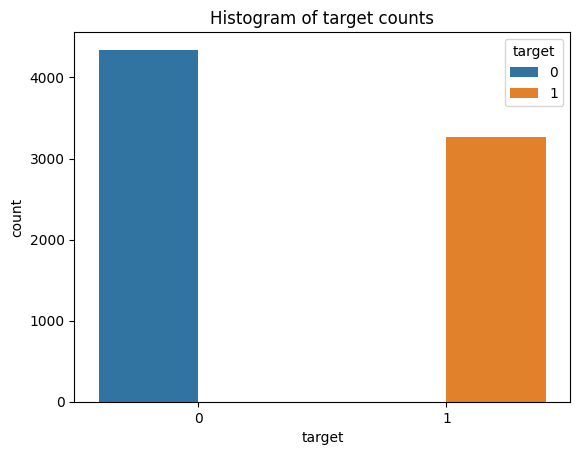

In [8]:
# See counts of each target.
print(train.target.value_counts())

# Plot the dataframe by target.
sns.countplot(train, x='target', hue='target')
plt.title('Histogram of target counts')

In the training data, there are 4,342 non-disaster tweets and 3,271 disaster tweets. 

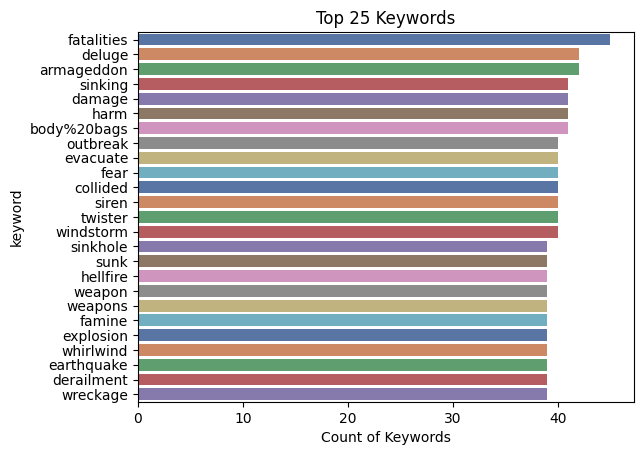

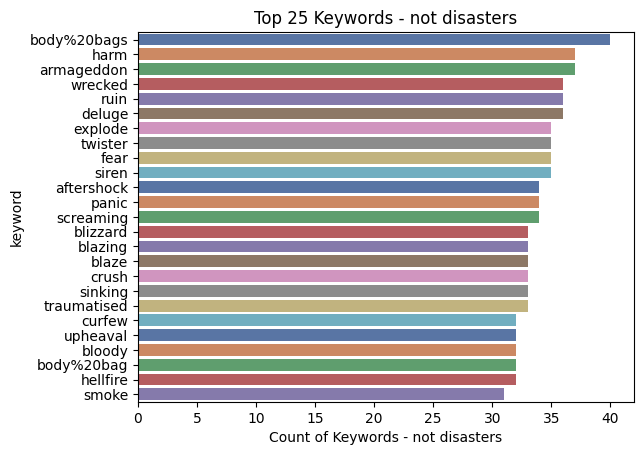

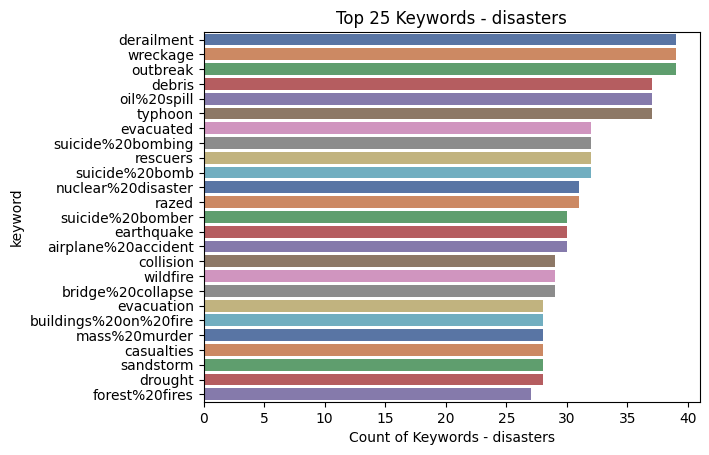

In [9]:
# Plot top 25 keywords.
keywords=train['keyword'].value_counts()[:25]
sns.barplot(x=keywords,y=keywords.index,palette='deep')
plt.title("Top 25 Keywords")
plt.xlabel("Count of Keywords")
plt.show()

# Plot top 25 keywords that are not disasters.
keywords=train[train['target'] == 0]['keyword'].value_counts()[:25]
sns.barplot(x=keywords,y=keywords.index,palette='deep')
plt.title("Top 25 Keywords - not disasters")
plt.xlabel("Count of Keywords - not disasters")
plt.show()

# Plot top 25 keywords that are  disasters.
keywords=train[train['target'] == 1]['keyword'].value_counts()[:25]
sns.barplot(x=keywords,y=keywords.index,palette='deep')
plt.title("Top 25 Keywords - disasters")
plt.xlabel("Count of Keywords - disasters")
plt.show()

## Investigate word and character counts

         count       mean       std  min   25%   50%   75%   max
target                                                          
0       4342.0  14.704744  6.161564  1.0  10.0  15.0  19.0  31.0
1       3271.0  15.167533  5.096806  2.0  11.0  15.0  19.0  30.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


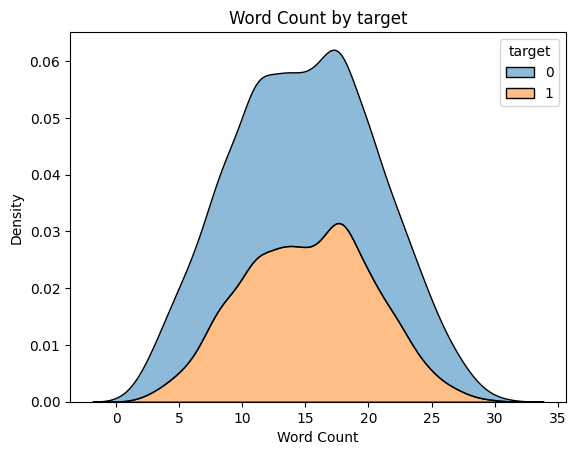

In [10]:
# Get the word count for each tweet.
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))

# Group by 'target' and compute the summary stats of 'word_count' in each group.
word_counts = train.groupby('target')['word_count'].describe()
print(word_counts)

# Create a desity plot. 
sns.kdeplot(train, x='word_count', hue='target', multiple="stack", alpha=.5,)
plt.xlabel('Word Count')
plt.title('Word Count by target')
plt.show()

The word counts for disaster tweets and non-disaster tweets have similar distributions but different densities.

         count        mean        std   min   25%    50%    75%    max
target                                                                
0       4342.0   95.706817  35.885924   7.0  68.0  101.0  130.0  157.0
1       3271.0  108.113421  29.309854  14.0  88.0  115.0  136.0  151.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


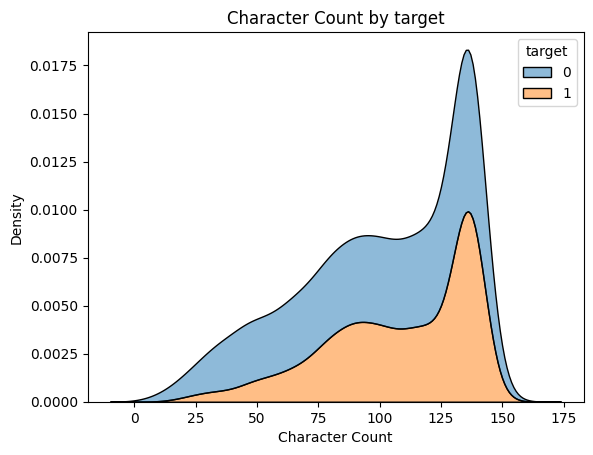

In [11]:
# Get the character count for each tweet.
train['char_count'] = train['text'].apply(lambda x: len(str(x)))

# Group by 'target' and compute the summary stats of 'char_count' in each group.
char_counts = train.groupby('target')['char_count'].describe()
print(char_counts)

# Create a density plot. 
sns.kdeplot(train, x='char_count', hue='target', multiple="stack", alpha=.5,)
plt.xlabel('Character Count')
plt.title('Character Count by target')
plt.show()


The character counts for disaster tweets and non-disaster tweets have similar distributions but different densities.

## Cleaning the text

There are a lot of different things we want to clean about our data, especially since this is tweet data. In tweet data there tends to be a lot of contractions to reduce character counts of the tweet. There also might be a lot of stop words, emojis, urls, numbers, and punctuation. 

In [12]:
# Download stopwords from NLTK.
nltk.download('stopwords')

def clean_text(text):
    # Create a dictionary of English Contractions.
    contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                         "can't": "cannot","can't've": "cannot have",
                         "'cause": "because","could've": "could have","couldn't": "could not",
                         "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                         "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                         "hasn't": "has not","haven't": "have not","he'd": "he would",
                         "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                         "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                         "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                         "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                         "it'd": "it would","it'd've": "it would have","it'll": "it will",
                         "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                         "mayn't": "may not","might've": "might have","mightn't": "might not", 
                         "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                         "mustn't've": "must not have", "needn't": "need not",
                         "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                         "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                         "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                         "she'll": "she will", "she'll've": "she will have","should've": "should have",
                         "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                         "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                         "there'd've": "there would have", "they'd": "they would",
                         "they'd've": "they would have","they'll": "they will",
                         "they'll've": "they will have", "they're": "they are","they've": "they have",
                         "to've": "to have","wasn't": "was not","we'd": "we would",
                         "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                         "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                         "what'll've": "what will have","what're": "what are", "what've": "what have",
                         "when've": "when have","where'd": "where did", "where've": "where have",
                         "who'll": "who will","who'll've": "who will have","who've": "who have",
                         "why've": "why have","will've": "will have","won't": "will not",
                         "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                         "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                         "y'all'd've": "you all would have","y'all're": "you all are",
                         "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                         "you'll": "you will","you'll've": "you will have", "you're": "you are",
                         "you've": "you have"}

    # Regular expression for finding contractions.
    contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

    def expand_contractions(s, contractions_dict=contractions_dict):
        def replace(match):
            return contractions_dict[match.group(0)]
        return contractions_re.sub(replace, s)

    # Expanding Contractions in the text.
    text = expand_contractions(text)

    # Lowercase the text.
    text = text.lower()

    # Remove URLs and replace with "url".
    text = re.sub(r'http\S+|www.\S+', 'url', text)

    # Remove html tags and replace with "html".
    text = re.sub(r'<.*?>', 'html', text)

    # Remove non-ASCII characters.
    text = text.encode("ascii", "ignore").decode()

    # Remove mentions and replace with "user".
    text = re.sub(r'@\w+', 'user', text)

    # Remove numbers and replace with "number".
    text = re.sub(r'\d+', 'number', text)

    # Replace emojis with "emoji".
    text = emoji.demojize(text, delimiters=(" ", " "))

    # Replace <3 with "heart".
    text = text.replace('<3', 'heart')

    # Remove punctuation.
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords.
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

# Apply the function to the 'text' column.
train_updated = train
train_updated['text'] = train['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
train_updated.head()

,id,keyword,location,text,target,word_count,char_count
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,13,69
1,4,NaN,NaN,forest fire near la ronge sask canada,1,7,38
2,5,NaN,NaN,residents asked ishelter place notified office...,1,22,133
3,6,NaN,NaN,numbernumber people receive wildfires evacuati...,1,8,65
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,16,88


# Models



The models I am choosing to use are different recurrent neural networks (RNN), specifically long short-term memory (LSTM) and gated recurrent unit (GRU) models. I will then try to optimize a few hyperparameters or add already built weights to try and get a better model.

Simple RNNs are comprised of an input, a hidden state updated through recurrent connections, and an output.

LSTM differ from simple RNNs by adding and including a cell state. This cell state is used for long term memory.

GRUs differ from simple RNNs by using a reset gate and update gate based on moving average. This simplifies the architecture compared to LSTM but maintains a similar performance. 

For a simple models test, I will have an embedding layer, one of the models (LSTM and GRU) layer, followed by the activation function. Embedding will encode each word with a number. 

Once our models are built we can process our data, split our data into training and validation sets, compile our model, and fit our model. When compiling we will use is Adaptive Moment Estimation (Adam) optimizer which is a stochastic gradient descent that scales the learning rate. 



In [14]:
# Create simple LSTM Model.
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=10000, output_dim=32))
model_lstm.add(LSTM(32))
model_lstm.add(Dense(1, activation='sigmoid'))

# Create simple GRU Model.
model_gru = Sequential()
model_gru.add(Embedding(input_dim=10000, output_dim=32))
model_gru.add(GRU(32))
model_gru.add(Dense(1, activation='sigmoid'))


In [15]:
# Tokenize and pad sequences.
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_updated['text'])
sequences = tokenizer.texts_to_sequences(train_updated['text'])
data = pad_sequences(sequences, maxlen=100)

# Split data into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(data, train_updated['target'], test_size=0.2, random_state=1234)

# Compile the models.
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the models.
model_lstm.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
model_gru.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Make predictions on the validation data.
predictions_lstm = model_lstm.predict(X_val)
predictions_gru = model_gru.predict(X_val)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6200 - loss: 0.6460 - val_accuracy: 0.7997 - val_loss: 0.4485
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8477 - loss: 0.3563 - val_accuracy: 0.7886 - val_loss: 0.4735
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9130 - loss: 0.2217 - val_accuracy: 0.7807 - val_loss: 0.5188
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9456 - loss: 0.1604 - val_accuracy: 0.7682 - val_loss: 0.6241
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9609 - loss: 0.1195 - val_accuracy: 0.7643 - val_loss: 0.6916
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9681 - loss: 0.0976 - val_accuracy: 0.7551 - val_loss: 0.7509
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9759 - loss: 0.0779 - val_accuracy: 0.7584 - val_loss: 0.8212
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9733 - loss: 0.0787 - val

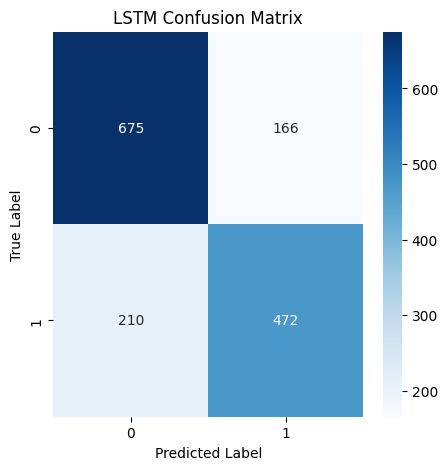

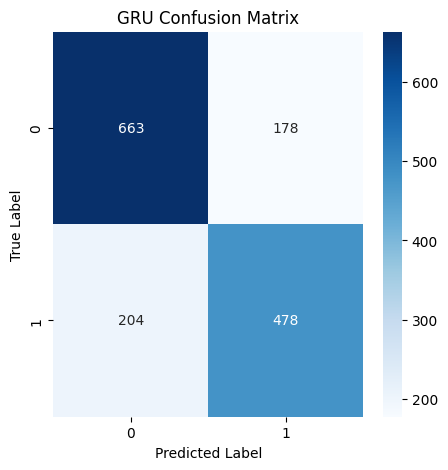

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       841
           1       0.74      0.69      0.72       682

    accuracy                           0.75      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.75      0.75      0.75      1523

GRU Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       841
           1       0.73      0.70      0.71       682

    accuracy                           0.75      1523
   macro avg       0.75      0.74      0.75      1523
weighted avg       0.75      0.75      0.75      1523



In [16]:
y_pred_lstm = predictions_lstm
y_pred_gru = predictions_gru

# Convert probabilities to binary predictions.
y_pred_lstm = np.round(y_pred_lstm).astype(int)
y_pred_gru = np.round(y_pred_gru).astype(int)

# Create confusion matrices.
cm_lstm = confusion_matrix(y_val, y_pred_lstm)
cm_gru = confusion_matrix(y_val, y_pred_gru)

# Plot confusion matrix.
def plot_cm(cm, model_name):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrices.
plot_cm(cm_lstm, 'LSTM')
plot_cm(cm_gru, 'GRU')

# Print classification reports.
report_lstm = classification_report(y_val, y_pred_lstm)
report_gru = classification_report(y_val, y_pred_gru)

print(f'LSTM Classification Report:\n{report_lstm}')
print(f'GRU Classification Report:\n{report_gru}')


The LSTM and GRU models have similar performance but the LSTM might be slightly better when it comes to recall on the disaster tweets. 

In [17]:
# # Clean the test data. 
# test['cleaned_text'] = test['text'].apply(clean_text)

# # Tokenize and pad sequences for test data.
# test_sequences = tokenizer.texts_to_sequences(test['cleaned_text'])
# test_data = pad_sequences(test_sequences, maxlen=100)

# # Make predictions on the test data.
# predictions_test_gru = model_gru.predict(test_data)

# # Convert probabilities to binary predictions
# test['target'] = np.round(predictions_test_gru).astype(int)

# # Merge the solutions dataframe with the predictions dataframe on the 'id' column.
# merged_df = solutions.merge(test, on='id')

# # Keep only the 'id' and 'target' columns.
# final_df = merged_df[['id', 'target_y']]

# # Rename the columns to their original names.
# final_df.columns = ['id', 'target']
# final_df.to_csv('submission.csv', index=False)
# print(final_df)

Score after submitting = 75.911%

## Hyperparameter tuning

I wanted to see if we get better performance if we use a dropout and recurrent dropout for our LSTM model. This will drop or set some weights to 0 within the model. 

In [18]:
# Create lstm model with dropout and recurrent dropout.
model_lstm_2 = Sequential()
model_lstm_2.add(Embedding(input_dim=10000, output_dim=32))
model_lstm_2.add(LSTM(32, dropout=0.2, recurrent_dropout=0.4))
model_lstm_2.add(Dense(1, activation='sigmoid'))
model_lstm_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Tokenize and pad sequences.
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_updated['text'])
sequences = tokenizer.texts_to_sequences(train_updated['text'])
data = pad_sequences(sequences, maxlen=100)

# Split data into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(data, train_updated['target'], test_size=0.2, random_state=1234)


# Train the model.
model_lstm_2.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Make predictions on the validation data.
predictions_lstm_2 = model_lstm_2.predict(X_val)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6017 - loss: 0.6521 - val_accuracy: 0.7886 - val_loss: 0.4692
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8343 - loss: 0.3930 - val_accuracy: 0.7984 - val_loss: 0.4480
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9001 - loss: 0.2619 - val_accuracy: 0.7827 - val_loss: 0.5013
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9262 - loss: 0.2044 - val_accuracy: 0.7781 - val_loss: 0.5861
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9509 - loss: 0.1480 - val_accuracy: 0.7761 - val_loss: 0.6261
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9577 - loss: 0.1235 - val_accuracy: 0.7603 - val_loss: 0.7102
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9669 - loss: 0.1049 - val_accuracy: 0.7564 - val_loss: 0.8096
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9707 - loss: 0.0920 - val_

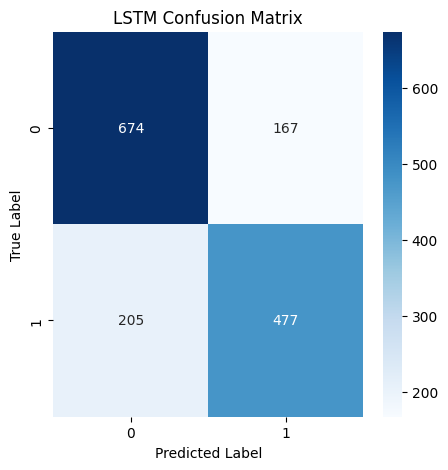

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       841
           1       0.74      0.70      0.72       682

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.75      1523



In [19]:
# Convert probabilities to binary predictions.
y_pred_lstm_2 = np.round(predictions_lstm_2).astype(int)

# Create confusion matrices.
cm_lstm_2 = confusion_matrix(y_val, y_pred_lstm_2)

# Function to plot confusion matrix.
def plot_cm(cm, model_name):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrices.
plot_cm(cm_lstm_2, 'LSTM')

# Print classification reports.
report_lstm = classification_report(y_val, y_pred_lstm_2)

print(f'LSTM Classification Report:\n{report_lstm}')



Simple LSTM Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       841
           1       0.71      0.73      0.72       682

    accuracy                           0.74      1523
    macro avg       0.74      0.74     0.74      1523
    weighted avg    0.74      0.74     0.74      1523

The perfomance of this model is maybe a little better when including dropout and recurrent dropout. The accuracy and recall for predicting 0 went up a few percentage points but there was not big jump in performance. Recall for calling disaster tweets went down by a couple of percentage points. 

I also tried adding another LSTM layer as well as dropping layers but the performance was not as good as this the above model. 

I also wanted to try to see if I could increase the performance of the GRU model. To do this, I not only added dropout and recurrent dropout but I also added another GRU layer and dropout between the GRU layers. 

In [20]:
# Create a GRU Model with multiple GRU layers and dropouts. 
model_gru_2 = Sequential()
model_gru_2.add(Embedding(input_dim=10000, output_dim=32))
model_gru_2.add(GRU(32, dropout=0.2, return_sequences=True, recurrent_dropout=0.4))
model_gru_2.add(Dropout(0.2))
model_gru_2.add(GRU(32, dropout=0.2, recurrent_dropout=0.4))
model_gru_2.add(Dropout(0.2))
model_gru_2.add(Dense(1, activation='sigmoid'))

# Tokenize and pad sequences.
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_updated['text'])
sequences = tokenizer.texts_to_sequences(train_updated['text'])
data = pad_sequences(sequences, maxlen=100)

# Split data into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(data, train_updated['target'], test_size=0.2, random_state=1234)

# Compile the model.
model_gru_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model.
model_gru_2.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Make predictions on the validation data.
predictions_gru_2 = model_gru_2.predict(X_val)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.5900 - loss: 32.1950 - val_accuracy: 0.7374 - val_loss: 0.6069
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.8089 - loss: 0.4941 - val_accuracy: 0.7820 - val_loss: 0.4865
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.8697 - loss: 0.3442 - val_accuracy: 0.7853 - val_loss: 0.4732
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.9034 - loss: 0.2656 - val_accuracy: 0.7702 - val_loss: 0.4917
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.9252 - loss: 0.2080 - val_accuracy: 0.7610 - val_loss: 0.5257
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.9408 - loss: 0.1750 - val_accuracy: 0.7584 - val_loss: 0.5718
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.9515 - loss: 0.1482 - val_accuracy: 0.7564 - val_loss: 0.6104
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.9568 - loss: 0.1266 -

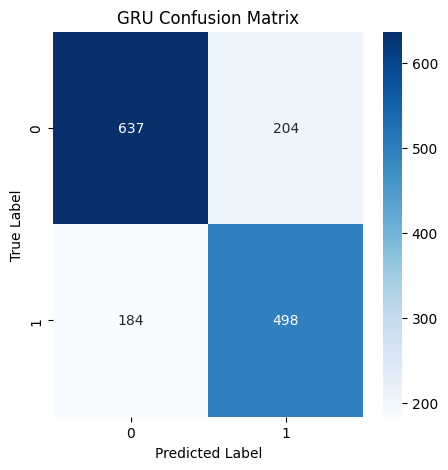

GRU Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       841
           1       0.71      0.73      0.72       682

    accuracy                           0.75      1523
   macro avg       0.74      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523



In [21]:
# Convert probabilities to binary predictions.
y_pred_gru_2 = np.round(predictions_gru_2).astype(int)

# Create confusion matrices.
cm_gru_2 = confusion_matrix(y_val, y_pred_gru_2)

# Function to plot confusion matrix.
def plot_cm(cm, model_name):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrices.
plot_cm(cm_gru_2, 'GRU')

# Print classification reports.
report_lstm = classification_report(y_val, y_pred_gru_2)

print(f'GRU Classification Report:\n{report_lstm}')


Simple GRU Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       841
           1       0.71      0.71      0.71       682

    accuracy                           0.74      1523
    macro avg       0.74      0.74     0.74      1523
    weighted avg    0.74      0.74     0.74      1523
    
    
When adding dropouts and recurrent dropouts as well as an additional GRU layer, the performance stayed about the same if not got slightly worse.

I did try different batch sizes too but they were not as good as the complex model above. 

## Word2Vec

Finally, I wanted to try vectorizing the tweets using Word2Vec and using those embeddings in the model. Word2Vec is comprised of some algorithms to vectorize text.

By applying this vectorization to the GRU model, does it make the model perform better?

14749
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5947 - loss: 0.6713 - val_accuracy: 0.6527 - val_loss: 0.6233
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7262 - loss: 0.5535 - val_accuracy: 0.7958 - val_loss: 0.4669
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8472 - loss: 0.3618 - val_accuracy: 0.7859 - val_loss: 0.4594
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8872 - loss: 0.2909 - val_accuracy: 0.7814 - val_loss: 0.4799
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9099 - loss: 0.2287 - val_accuracy: 0.7695 - val_loss: 0.5146
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9264 - loss: 0.1908 - val_accuracy: 0.7577 - val_loss: 0.5647
Epoch 6: early stopping
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


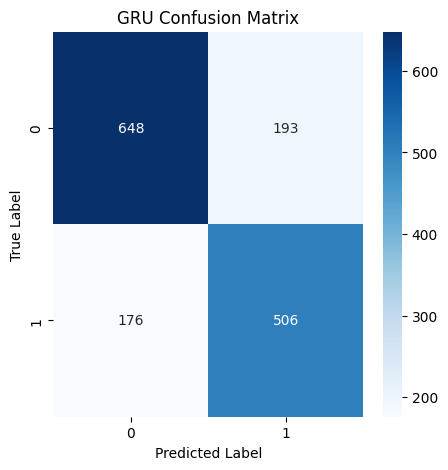

GRU Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       841
           1       0.72      0.74      0.73       682

    accuracy                           0.76      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.76      0.76      0.76      1523



In [22]:
# Add text to a list.
tweets = train_updated['text'].apply(str.split).tolist()

# Create vectors for our tweets. 
model_word = Word2Vec(tweets, vector_size=32, window=2, min_count=1)
model_word.save("word2vec.model")

# Load Word2Vec model. 
model_word = Word2Vec.load("word2vec.model")

# Tokenize and pad sequences.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_updated['text'])
sequences = tokenizer.texts_to_sequences(train_updated['text'])
data = pad_sequences(sequences, maxlen=32)
print(len(tokenizer.word_index))

# Create a weight matrix for words in training.
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 32))

for word, i in tokenizer.word_index.items():
    if word in model_word.wv:
        embedding_vector = model_word.wv[word]
        embedding_matrix[i] = embedding_vector

# Use this embedding matrix in the `Embedding` layer.
model_gru_3 = Sequential()
model_gru_3.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=32, embeddings_initializer=Constant(embedding_matrix)))
model_gru_3.add(GRU(32, dropout=0.2, recurrent_dropout=0.4))
model_gru_3.add(Dense(1, activation='sigmoid'))


# Split data into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(data, train_updated['target'], test_size=0.2, random_state=1234)

# Compile the model.
model_gru_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the early stopping criteria.
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Train the model.
model_gru_3.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stop])

# Make predictions on the validation data.
predictions_gru_3 = model_gru_3.predict(X_val)

# Convert probabilities to binary predictions.
y_pred_gru_3 = np.round(predictions_gru_3).astype(int)

# Create confusion matrix.
cm_gru_3 = confusion_matrix(y_val, y_pred_gru_3)

# Function to plot confusion matrix.
def plot_cm(cm, model_name):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_cm(cm_gru_3, 'GRU')

# Print classification reports.
report_lstm = classification_report(y_val, y_pred_gru_3)

print(f'GRU Classification Report:\n{report_lstm}')

Simple GRU Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       841
           1       0.71      0.71      0.71       682

    accuracy                           0.74      1523
    macro avg       0.74      0.74     0.74      1523
    weighted avg    0.74      0.74     0.74      1523
    
    
GRU with drop outs Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       841
           1       0.71      0.70      0.70       682

    accuracy                           0.74      1523
    macro avg       0.73      0.73     0.73      1523
    weighted avg    0.74      0.74     0.74      1523
    
    
    
The model using Word2Vec maybe does slightly better than the other two models. It has better precision but slightly less recall when looking at non-disaster tweets when compared to the other two models. It does have the best recall for disaster tweets when compared to the other models and about the same precision for disaster tweets. 

In [23]:
# Clean the test data. 
test['cleaned_text'] = test['text'].apply(clean_text)
test_tweets = test['cleaned_text'].apply(str.split).tolist()

# Tokenize and pad sequences for test data.
test_sequences = tokenizer.texts_to_sequences(test_tweets)
test_data = pad_sequences(test_sequences, maxlen=32)

# Make predictions on the test data.
predictions_test_gru = model_gru_3.predict(test_data)

# Convert probabilities to binary predictions
test['target'] = np.round(predictions_test_gru).astype(int)

# Merge the solutions dataframe with the predictions dataframe on the 'id' column.
merged_df = solutions.merge(test, on='id')

# Keep only the 'id' and 'target' columns.
final_df = merged_df[['id', 'target_y']]

# Rename the columns to their original names.
final_df.columns = ['id', 'target']
final_df.to_csv('submission.csv', index=False)
print(final_df)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
         id  target
0         0       0
1         2       1
2         3       1
3         9       1
4        11       1
...     ...     ...
3258  10861       0
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       1

[3263 rows x 2 columns]


Score after submitting = 76.432%

# Conclusion

### Overview

The GRU model with the Words2Vec embeddings gave the best performance of all of the models tested in this notebook. When looking at the validation tests, the GRU model with the Words2Vec was one of the highest precision and recalls for both non-disaster tweets. Following that both the more complex GRU and LSTM models did better than the simple models tended to predict not a disaster when there really was a disaster. 

Finally, the GRU model with the Words2Vec embeddings gave the best submission score with a 76.432% when compared to the simple LSTM model which got a 75.911%. Given how close the models are, the LSTM model might be the one you choose for the models tested in this notebook. It is a simpler model and took less time to run but gave almost the same score for the submission.csv. 


### Addtional testing

If time persisted, there are some other things that I would try. Even though I tried a few different batches, I would try a few more. I also think using different embeddings could be interesting and improve performance. Using something like BERT might bring in better embeddings for the weights. Also, trying different combinations of the model layers could increase performance (Ex: LSTM layer + LSTM layer + sigmoid). Finally, we could look at the text more and see if there were any abbreviations or text that does not make sense. This would give the model more words and might lead to better predictions. 

# References

Tensorflow

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

https://radimrehurek.com/gensim/models/word2vec.html

https://www.tensorflow.org/text/guide/word_embeddings

https://www.tensorflow.org/text/guide/tokenizers

https://www.tensorflow.org/text/tutorials/text_classification_rnn

Kaggle

https://www.kaggle.com/code/zinebkhanjari/disaster-tweets-multiple-vectorizers-and-models#Models

https://www.kaggle.com/code/sandhyakrishnan02/nlp-with-disaster-tweets-using-lstm